In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import csv
import time

import sys
sys.path.insert(0, "../../utils/")
import utils as ut
import fancyplots as fp

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MeanSquaredError
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras import backend as K

## Input options

In [3]:
data2use         = 'NewRealistic' # 'NewRealistic' or 'GSTLAL_2m'

# training options
write_output     = True
remove_some_mass = False
epochs           = 250
validation_split = 0.1
batch_size       = 64
verbose_training = True
hlayers_sizes    = [100];
learning_rate    = 0.001
scaler_type      = 'mixed'  # standard, minmax, mixed
activation       = 'relu'
out_activation   = 'linear_cut_mod' # sigmoid, linear, linear_cut, linear_cut_T3, linear_cut_lb, linear_cut_mod

## Check on input and dictionary-initialization

In [4]:
if data2use=='NewRealistic':
    features_names   = ['m1', 'm2', 's1x', 's1y', 's1z', 's2x', 's2y', 's2z',\
                        'theta', 'q', 'Mc'];
    regr_data_dir    = '../../datasets/NewRealistic/'
    out_data_dir     = '../../datasets/NN_tf_results/'
    versions         = ['0'] # can be a subset of ['0', '1', '2']
    clabels          = ['0'] # can be a subset of ['0', '1'] 

    # define dictionary for each version considered
    Nv       = len(versions)
    Nc       = len(clabels)
    Nsets    = Nv*Nc

    if Nv*Nc!=Nsets:
        print('+++ Wrong input! +++')

    datasets = {}
    keys     = []
    for i in range(0,Nv):
        version = versions[i]
        for j in range(0,Nc):
            clabel = clabels[j]
            key = 'v'+version+'c'+clabel
            keys.append(key)
            datasets[key]         = lambda:0
            datasets[key].clabel  = clabel
            datasets[key].version = version
            data_paths           = {}
            data_paths['xtrain'] = regr_data_dir+key+'train_x.csv'
            data_paths['ytrain'] = regr_data_dir+key+'train_y.csv'
            data_paths['xtest']  = regr_data_dir+key+'test_x.csv'
            data_paths['ytest']  = regr_data_dir+key+'test_y.csv'
            datasets[key].data_paths = data_paths
            
elif data2use=='GSTLAL_2m':
    features_names    = ['m1', 'm2']
    regr_data_dir     = '../../datasets/GSTLAL_EarlyWarning_Dataset/Dataset/'
    out_data_dir      = '../../datasets/GSTLAL_EarlyWarning_Dataset/Regression_Result/NN_tf/'
    datasets          = {}
    keys              = ['GSTLAL_2m']
    key               = keys[0]
    datasets[key]     = lambda:0
    data_paths           = {}
    data_paths['xtrain'] = regr_data_dir+'train_recover.csv'
    data_paths['ytrain'] = regr_data_dir+'train_inject.csv'
    data_paths['xtest']  = regr_data_dir+'test_recover.csv'
    data_paths['ytest']  = regr_data_dir+'test_inject.csv'
    datasets[key].data_paths = data_paths

else:
    print("'data2use' can be 'NewRealistic' or 'GSTLAL_2m'")
    sys.exit()

In [5]:
# define all the ouput activation functions
def output_activation_sigmoid(x):
    return K.sigmoid(x)*2-1

def output_activation_linear(x):
    return x

def output_activation_linear_cut(x):
    signs = K.switch(x>0, 1+x*0, -1+x*0) # x*0 in order to broadcast to correct dimension
    return K.switch(abs(x)<1, x, signs)

def output_activation_linear_cut_T3(x):
    return 2/(K.exp(-(2*x+2/3*x*x*x))+1)-1

def output_activation_linear_cut_lb(x):
    return K.switch(x>-1, x, -1+x*0)

# define model using Functional API
def buildModelUsingFunctionalAPI(hlayers_sizes, batch_size, Nfeatures, out_activation='linear'):
    model_input = tf.keras.Input(shape=(Nfeatures))
    x = Dense(hlayers_sizes[0], kernel_initializer='normal', activation=activation)(model_input)
    for i in range(1, len(hlayers_sizes)):
        x = Dense(hlayers_sizes[i], kernel_initializer='normal', activation=activation)(x)
    
    if out_activation=="sigmoid":
        out = Dense(Nfeatures, kernel_initializer='normal',\
                    activation=output_activation_sigmoid)(x)
    
    elif out_activation=="linear":
        out = Dense(Nfeatures, kernel_initializer='normal',\
                    activation=output_activation_linear)(x)
        
    elif out_activation=="linear_cut":
        out = Dense(Nfeatures, kernel_initializer='normal',\
                    activation=output_activation_linear_cut)(x)    
    
    elif out_activation=="linear_cut_T3":
        out = Dense(Nfeatures, kernel_initializer='normal',\
                    activation=output_activation_linear_cut_T3)(x)
    
    elif out_activation=="linear_cut_lb":
        out = Dense(Nfeatures, kernel_initializer='normal',\
                    activation=output_activation_linear_cut_lb)(x)
    
    elif out_activation=="linear_cut_mod":
        if Nfeatures==11:
            neuronsA = 2 # m1, m2
            neuronsB = 6 # s1,s2,
            neuronsC = 1 # theta
            neuronsD = 2 # q, Mc
        elif Nfeatures==9:
            neuronsA = 1 # m1
            neuronsB = 6 # s1,s2
            neuronsC = 1 # theta
            neuronsD = 1 # Mc
        else:
            print("'linear_cut_mod' is hardcoded for Nfeatures=9,11!")
            sys.exit()
        branchA = Dense(neuronsA, kernel_initializer='normal', activation=output_activation_linear_cut_lb)(x)
        branchB = Dense(neuronsB, kernel_initializer='normal', activation=output_activation_linear_cut)(x)
        branchC = Dense(neuronsC, kernel_initializer='normal', activation=output_activation_linear)(x)
        branchD = Dense(neuronsD, kernel_initializer='normal', activation=output_activation_linear_cut_lb)(x)
        out = tf.keras.layers.concatenate([branchA, branchB, branchC, branchD])

    return tf.keras.Model(model_input, out)

mse = MeanSquaredError()

## Loop on versions

********************************************************************************
Key: v0c0
********************************************************************************
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 11)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 100)          1200        ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 2)            202         ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)     

282/282 [==============================] - 1s 2ms/step - loss: 0.0130 - mean_squared_error: 0.0130 - accuracy: 0.8854 - val_loss: 0.0159 - val_mean_squared_error: 0.0159 - val_accuracy: 0.9125
Epoch 30/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0130 - mean_squared_error: 0.0130 - accuracy: 0.8821 - val_loss: 0.0159 - val_mean_squared_error: 0.0160 - val_accuracy: 0.9065
Epoch 31/250
282/282 [==============================] - 0s 2ms/step - loss: 0.0129 - mean_squared_error: 0.0129 - accuracy: 0.8848 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - val_accuracy: 0.9095
Epoch 32/250
282/282 [==============================] - 0s 2ms/step - loss: 0.0127 - mean_squared_error: 0.0128 - accuracy: 0.8858 - val_loss: 0.0162 - val_mean_squared_error: 0.0163 - val_accuracy: 0.9060
Epoch 33/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0126 - mean_squared_error: 0.0126 - accuracy: 0.8859 - val_loss: 0.0159 - val_mean_squared_error: 0.0159 - val_

Epoch 69/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - accuracy: 0.8921 - val_loss: 0.0138 - val_mean_squared_error: 0.0138 - val_accuracy: 0.9060
Epoch 70/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0111 - mean_squared_error: 0.0111 - accuracy: 0.8926 - val_loss: 0.0137 - val_mean_squared_error: 0.0138 - val_accuracy: 0.9100
Epoch 71/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0109 - mean_squared_error: 0.0109 - accuracy: 0.8948 - val_loss: 0.0137 - val_mean_squared_error: 0.0137 - val_accuracy: 0.8965
Epoch 72/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0109 - mean_squared_error: 0.0109 - accuracy: 0.8932 - val_loss: 0.0134 - val_mean_squared_error: 0.0134 - val_accuracy: 0.9045
Epoch 73/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - accuracy: 0.8930 - val_loss: 0.0129 - val_mean_squared_error: 

Epoch 109/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - accuracy: 0.8968 - val_loss: 0.0132 - val_mean_squared_error: 0.0132 - val_accuracy: 0.9075
Epoch 110/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - accuracy: 0.8986 - val_loss: 0.0132 - val_mean_squared_error: 0.0133 - val_accuracy: 0.9100
Epoch 111/250
282/282 [==============================] - 0s 2ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - accuracy: 0.8989 - val_loss: 0.0123 - val_mean_squared_error: 0.0124 - val_accuracy: 0.9060
Epoch 112/250
282/282 [==============================] - 0s 2ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - accuracy: 0.8984 - val_loss: 0.0130 - val_mean_squared_error: 0.0130 - val_accuracy: 0.9065
Epoch 113/250
282/282 [==============================] - 0s 2ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - accuracy: 0.9009 - val_loss: 0.0122 - val_mean_squared_er

282/282 [==============================] - 1s 2ms/step - loss: 0.0097 - mean_squared_error: 0.0096 - accuracy: 0.8993 - val_loss: 0.0116 - val_mean_squared_error: 0.0116 - val_accuracy: 0.9140
Epoch 149/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0096 - mean_squared_error: 0.0096 - accuracy: 0.9015 - val_loss: 0.0118 - val_mean_squared_error: 0.0119 - val_accuracy: 0.9090
Epoch 150/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0096 - mean_squared_error: 0.0096 - accuracy: 0.9012 - val_loss: 0.0119 - val_mean_squared_error: 0.0120 - val_accuracy: 0.9065
Epoch 151/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - accuracy: 0.8978 - val_loss: 0.0127 - val_mean_squared_error: 0.0127 - val_accuracy: 0.9090
Epoch 152/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0096 - mean_squared_error: 0.0096 - accuracy: 0.9002 - val_loss: 0.0117 - val_mean_squared_error: 0.0118 - 

Epoch 188/250
282/282 [==============================] - 1s 4ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - accuracy: 0.9013 - val_loss: 0.0124 - val_mean_squared_error: 0.0124 - val_accuracy: 0.9015
Epoch 189/250
282/282 [==============================] - 1s 3ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - accuracy: 0.9013 - val_loss: 0.0119 - val_mean_squared_error: 0.0119 - val_accuracy: 0.9095
Epoch 190/250
282/282 [==============================] - 1s 3ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - accuracy: 0.9021 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - val_accuracy: 0.9110
Epoch 191/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - accuracy: 0.9021 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - val_accuracy: 0.9075
Epoch 192/250
282/282 [==============================] - 1s 3ms/step - loss: 0.0094 - mean_squared_error: 0.0093 - accuracy: 0.9029 - val_loss: 0.0111 - val_mean_squared_er

282/282 [==============================] - 1s 2ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - accuracy: 0.9020 - val_loss: 0.0111 - val_mean_squared_error: 0.0112 - val_accuracy: 0.9120
Epoch 228/250
282/282 [==============================] - 0s 2ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - accuracy: 0.9023 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_accuracy: 0.9125
Epoch 229/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - accuracy: 0.9012 - val_loss: 0.0115 - val_mean_squared_error: 0.0115 - val_accuracy: 0.9140
Epoch 230/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - accuracy: 0.9036 - val_loss: 0.0122 - val_mean_squared_error: 0.0123 - val_accuracy: 0.9080
Epoch 231/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0093 - mean_squared_error: 0.0092 - accuracy: 0.9031 - val_loss: 0.0111 - val_mean_squared_error: 0.0112 - 

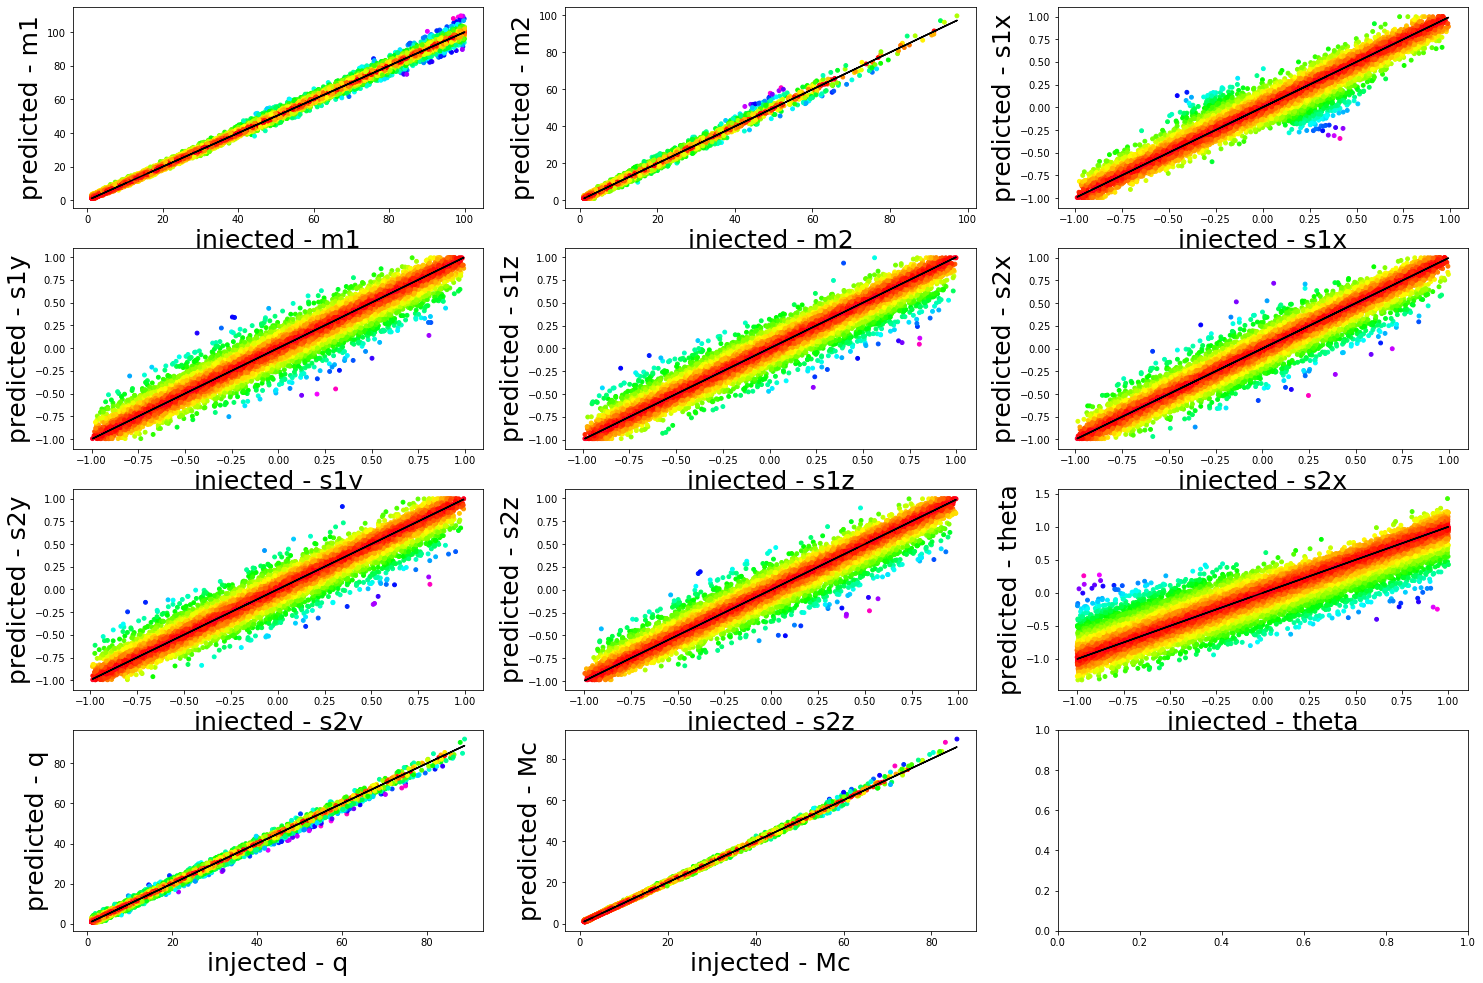

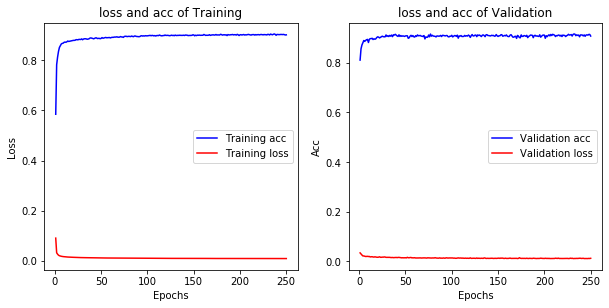

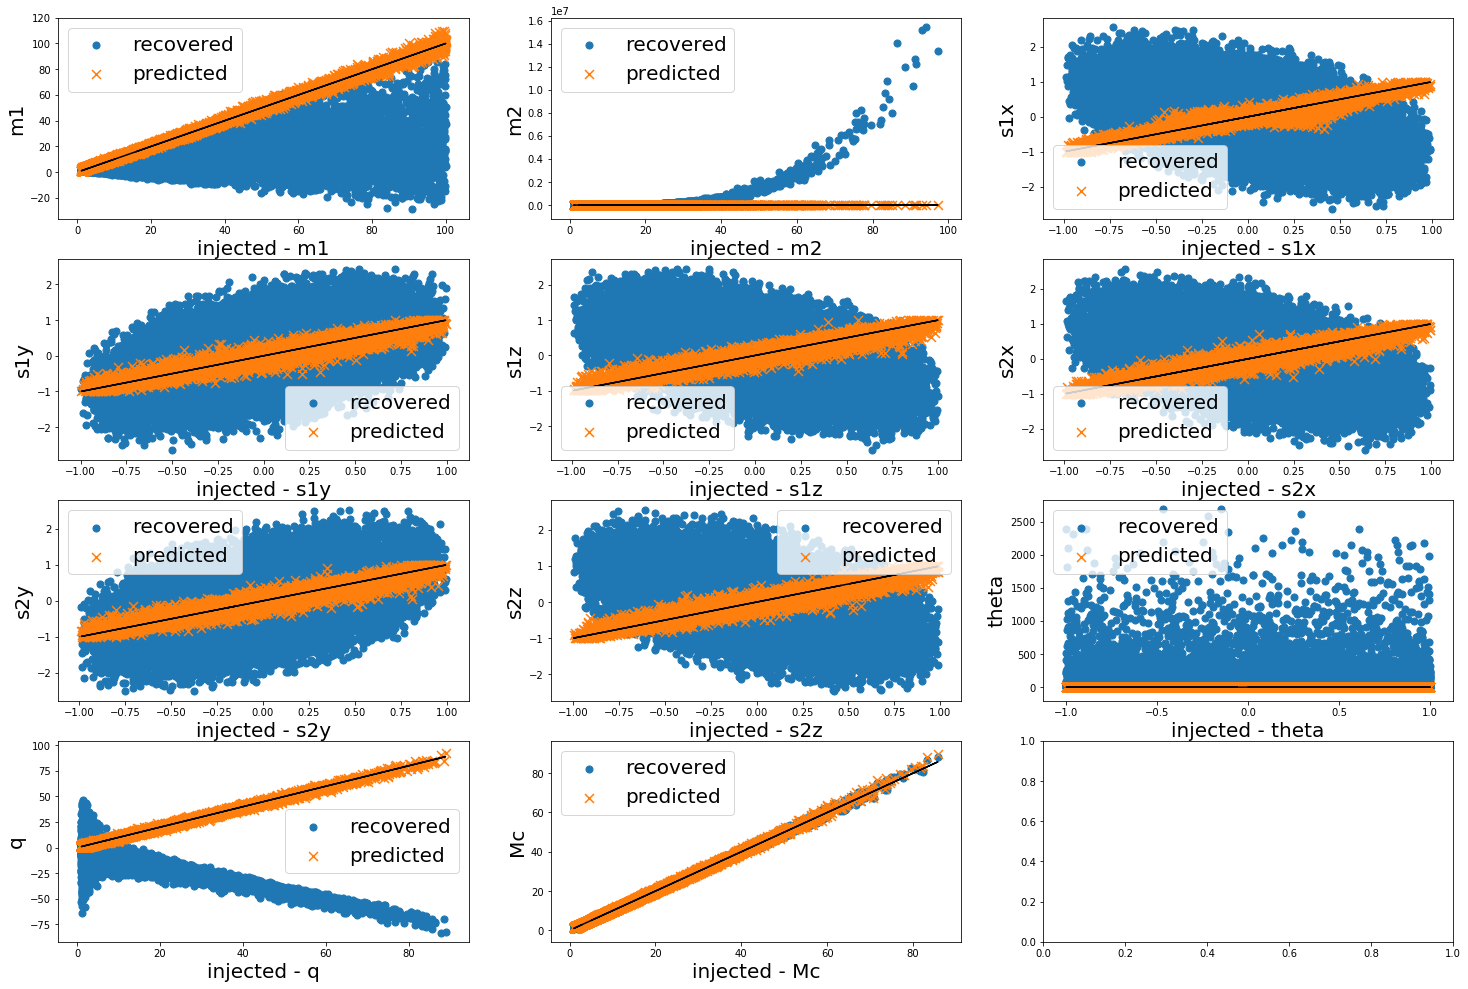

In [6]:
dashes = '*'*80

for key in keys:
    print(dashes, '\nKey: ', key, '\n', dashes, sep='')
    
    data_paths = datasets[key].data_paths
    
    rdl_out = ut.regressionDatasetLoader(data_paths, features_names,
                           scaler_type=scaler_type,
                           remove_some_mass=remove_some_mass)
    
    xtrain   = rdl_out['xtrain']
    ytrain   = rdl_out['ytrain']
    xtest    = rdl_out['xtest']
    ytest    = rdl_out['ytest']
    scaler_x = rdl_out['scaler_x']
    scaler_y = rdl_out['scaler_y']
    labels   = rdl_out['labels']
    
    Nfeatures = len(xtrain[0,:])
    
    # build, compile and train the model
    model = buildModelUsingFunctionalAPI(hlayers_sizes, batch_size, Nfeatures,\
                                         out_activation=out_activation)
    model.compile(
        loss=mse, 
        optimizer=Adam(learning_rate=learning_rate), 
        metrics=[mse, 'accuracy']
    )
    model.summary()
    t0 = time.perf_counter()
    history = model.fit(xtrain, ytrain, 
        epochs           = epochs, 
        batch_size       = batch_size,
        validation_split = validation_split,
        verbose          = verbose_training
    )
    train_time = time.perf_counter()-t0
    
    # predict
    ypredicted = model.predict(xtest)
    
    # print some information
    metrics_dict = ut.evalutationMetricsDict(xtest,ytest,model)
    ut.printMetrics(metrics_dict)

    # update dictionary adding data (both normalized and not), model and score
    datasets[key].train_time = train_time
    datasets[key].model      = model
    datasets[key].history    = history
    datasets[key].predicted  = scaler_y.inverse_transform(ypredicted)
    datasets[key].metrics    = metrics_dict
    datasets[key].Ntrain     = len(xtrain[:,0])
    
    # plots
    fp.regrPredictionPlots(ytest, ypredicted, labels, scaler=scaler_y)
    fp.plotHistory(history)
    fp.checkRegressionPlot(xtest, ytest, ypredicted, labels, \
                       scaler_y=scaler_y, scaler_x=scaler_x)
    
    del model

## Produce CSV files

In [7]:
if write_output:
    for key in keys:
        # save csv
        filename = out_data_dir+'NN_tf_'+key+'.csv'
        ut.writeResult(filename, datasets[key].predicted, verbose=True)
        
        # save model
        #dict_name = out_data_dir+'NN_tf_'+key+'.dict'
        #pickle.dump(datasets[key].model, open(dict_name, 'wb'))
        #print(dict_name, 'saved') 
        
        # example for loading models
        #dict_name    = out_data_dir+'NN_tf_'+key+'.dict'
        #print('Loading', dict_name, '...')
        #loaded_model = pickle.load(open(dict_name, 'rb'))

../../datasets/NN_tf_results/NN_tf_v0c0.csv saved
